Import packages

In [1]:
#
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Reset graph

In [2]:
tf.reset_default_graph()

# Stacked Autoencoder

Import MNIST data

In [3]:
#
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('datasets\mnist')

Extracting datasets\mnist\train-images-idx3-ubyte.gz
Extracting datasets\mnist\train-labels-idx1-ubyte.gz
Extracting datasets\mnist\t10k-images-idx3-ubyte.gz
Extracting datasets\mnist\t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.images.min(axis=1)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

Some settings

In [5]:
#
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = 300
n_outputs = n_inputs
l2_reg = 0.0001

Build a stacked autoencoder that:
1. Three hidden layers
2. Use He initializer
3. Use ELU activation function
4. Use L2 regularization
5. Use partial function to make the code concise
6. Train autoencoder by 5 epoches with batch size of 150. 
7. Print out the training and validation loss after each epoch
8. Save the final model to tmp/autoencoder_stacked.ckpt
9. Visualize the training and validation error by TensorBoard

Not that the input data is already scalled to [0, 1]. So, you can use regularization directly. You can also try other strategies to preprocess the data. For example, standardize the data to N(0, 1) or scale the data to [-1, 1]

In [6]:
from functools import partial

In [7]:
he_initializer = tf.contrib.layers.variance_scaling_initializer()
L2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_reg)

In [8]:
my_layer = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=he_initializer, kernel_regularizer=L2_regularizer)

In [9]:
X = tf.placeholder(dtype=tf.float32, shape=(None, 28*28), name='X')

In [10]:
with tf.name_scope('NN'):
    hidden1 = my_layer(X, n_hidden1)
    encoder = my_layer(hidden1, n_hidden2)
    hidden3 = my_layer(encoder, n_hidden3)
    output = tf.layers.dense(hidden3, n_outputs, activation=None)

In [11]:
with tf.name_scope('loss'):
    mse = tf.reduce_mean(tf.square(X-output), name='mse')
    reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([mse]+reg_loss, name='loss')
    loss_sum = tf.summary.scalar(name='loss', tensor=loss)

In [12]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)

In [13]:
init = tf.global_variables_initializer()

In [14]:
n_epoch = 40
batch_size = 150
n_step = mnist.train.num_examples // batch_size

In [15]:
saver = tf.train.Saver()
train_file_writer = tf.summary.FileWriter(
    logdir='logs/autoencoder_stacked/tain', graph=tf.get_default_graph())
validation_file_writer = tf.summary.FileWriter(
    logdir='logs/autoencoder_stacked/validation', graph=tf.get_default_graph())

In [16]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epoch):
        for step in range(n_step):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(train_op, feed_dict={X: X_batch})
        [train_loss, train_loss_sum] = \
            sess.run([loss, loss_sum], feed_dict={X: mnist.train.images})
        [validation_loss, validation_loss_sum] = \
            sess.run([loss, loss_sum], feed_dict={X: mnist.validation.images})
        global_step = n_step * (epoch+1)
        train_file_writer.add_summary(train_loss_sum, global_step=global_step)
        validation_file_writer.add_summary(validation_loss_sum, global_step=global_step)
        print('Epoch: {}, training error: {}, validation error: {}'.format(epoch, train_loss, validation_loss))
    train_file_writer.close()
    validation_file_writer.close()
    
    saver.save(sess, 'tmp/autoencoder_stacked.ckpt')

Epoch: 0, training error: 0.03063550591468811, validation error: 0.030775021761655807
Epoch: 1, training error: 0.01805840991437435, validation error: 0.018131786957383156
Epoch: 2, training error: 0.014898489229381084, validation error: 0.014954058453440666
Epoch: 3, training error: 0.013650224544107914, validation error: 0.013692894019186497
Epoch: 4, training error: 0.012905944138765335, validation error: 0.01294369250535965
Epoch: 5, training error: 0.012455837801098824, validation error: 0.012493716552853584
Epoch: 6, training error: 0.012105235829949379, validation error: 0.012141624465584755
Epoch: 7, training error: 0.011830925941467285, validation error: 0.011868649162352085
Epoch: 8, training error: 0.011564189568161964, validation error: 0.011600840836763382
Epoch: 9, training error: 0.011368379928171635, validation error: 0.011406178586184978
Epoch: 10, training error: 0.0111741553992033, validation error: 0.01120991725474596
Epoch: 11, training error: 0.011047405190765858,

In another session, predict the output at the first two test image

In [17]:
with tf.Session() as sess:
    saver.restore(sess, 'tmp/autoencoder_stacked.ckpt')
    X_test = mnist.test.images[:2]
    output_val = output.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from tmp/autoencoder_stacked.ckpt


Visualize the first two test images. To compare, also visualize their predictions.

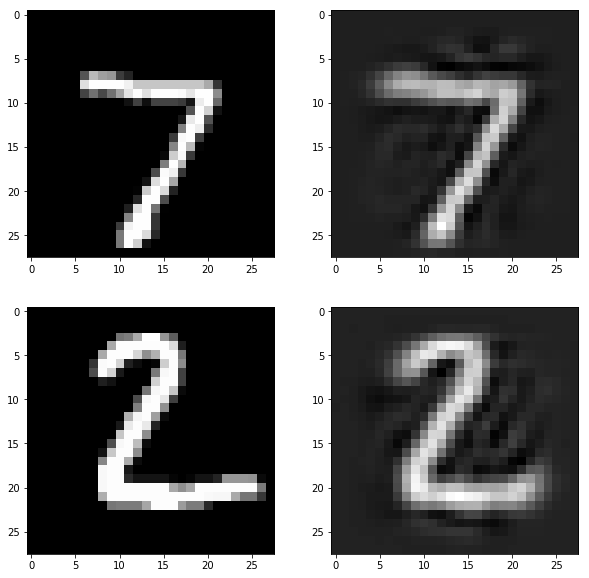

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(mnist.test.images[0, :].reshape([-1, 28]), cmap='gray')
axes[0, 1].imshow(output_val[0, :].reshape([-1, 28]), cmap='gray')
axes[1, 0].imshow(mnist.test.images[1, :].reshape([-1, 28]), cmap='gray')
axes[1, 1].imshow(output_val[1, :].reshape([-1, 28]), cmap='gray')